# Heart Disease Risk Prediction using Ensemble Learning

### Problem Statement:

Heart disease remains a leading cause of mortality worldwide, and early detection is crucial for timely intervention. Traditional diagnostic methods rely on medical tests and expert analysis, which can be time-consuming and prone to human error. This project aims to develop a machine learning-based predictive model that classifies whether a patient is at risk of heart disease based on various medical parameters such as age, blood pressure, cholesterol levels, and other health indicators.



### Solution Approach:

The proposed approach leverages an ensemble learning method using a Voting Classifier that combines multiple base models to improve predictive accuracy and robustness. The key steps include:
- Data Preprocessing: Handling missing values and feature scaling.
- Model Selection: Using an ensemble of Logistic Regression, Random Forest (with and without Hyperparameter tuning), SVM, and XGBoost.
- Soft Voting Classifier: Combining predictions of base models using probability-weighted voting.
- Evaluation & Optimization: Assessing model performance using Accuracy, Precision, Recall, F1-score, and MCC, with hyperparameter tuning for optimal performance.


### About the Dataset:

Dataset Link (Kaggle): https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

The dataset used in this project contains relevant medical attributes such as age, cholesterol levels, blood pressure, and ECG readings. A summary of the dataset is presented in the table below:

| Feature   | Description                                           |
|-----------|-------------------------------------------------------|
| age       | Patient age in years                                  |
| sex       | Gender of the patient (0 = Female, 1 = Male)          |
| cp        | Chest pain type (categorical: 0-3)                    |
| trestbps  | Resting blood pressure (mm Hg)                        |
| chol      | Serum cholesterol level (mg/dL)                       |
| fbs       | Fasting blood sugar (>120 mg/dL, 1 = True, 0 = False) |
| restecg   | Resting electrocardiographic results (0-2)            |
| thalach   | Maximum heart rate achieved                           |
| exang     | Exercise-induced angina (1 = Yes, 0 = No)             |
| oldpeak   | ST depression induced by exercise                     |
| slope     | Slope of peak exercise ST segment (0-2)               |
| ca        | Number of major vessels colored by fluoroscopy (0-4)  |
| thal      | Thalassemia type (0-3)                                |
| target    | Presence (1) or absence (0) of heart disease          |

- With 303 entries & a total 14 columns


### Install required libraries

In [1]:
!pip install os numpy pandas matplotlib seaborn scikit-learn ipywidgets

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


### Import required libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef)
from sklearn.ensemble import (VotingClassifier, StackingClassifier)
from imblearn.over_sampling import SMOTE
from collections import Counter
from tabulate import tabulate

import pickle
import joblib
import ipywidgets as widgets
from IPython.display import display

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [4]:
# Dataset path
dataset_path = 'heart_disease_data.csv'
data = pd.read_csv(dataset_path)

# Output folder to save plots
dirs = [
    "output",
    "output/logistic_regression",
    "output/random_forest",
    "output/svm",
    "output/xgboost",
    "output/ensemble",
    "output/ensemble/soft_voting",
    "output/ensemble/hard_voting",
    "output/ensemble/stacking"
]
for dir in dirs:
    os.makedirs(dir, exist_ok=True)

### Exploratory Data Analysis (EDA)

In [5]:
# View first 5 rows
print("------- Data Frame -------\n", data.head(), sep="\n")

------- Data Frame -------

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [6]:
# Show complete information about no. of entries, no. of columns, non-null values, data types
print("------- Information -------\n") ; data.info()

------- Information -------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Show missing values present if any, in each column
missing_values = data.isnull().sum()
missing_values_non_zero = missing_values[missing_values != 0]
if missing_values_non_zero.empty:
    print("No missing values found.")
else:
    print("------- Missing Values -------\n", missing_values_non_zero, sep="\n")

No missing values found.


In [8]:
# Show Mean, Median, Standard Deviaiton, Min, Max, Quartiles of each column
print("------- Describe -------\n", data.describe(), sep="\n")

------- Describe -------

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
s

In [9]:
# Dataset parameters
feature_list = data.columns.tolist()
print("Columns in the DataFrame:", feature_list)

Columns in the DataFrame: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [10]:
# Outlier detection using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((data < lower_bound) | (data > upper_bound)).sum()
# Print outliers before handling
print("------- Outliers Before Handling -------\n", outliers)
# Handle outliers by capping (Winsorization/Capping)
# data = data.apply(lambda x: x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95)), axis=0)
# Outliers after handling
# outliers_after_handling = ((data < lower_bound) | (data > upper_bound)).sum()
# print("------- Outliers After Handling -------\n", outliers_after_handling)

------- Outliers Before Handling -------
 age          0
sex          0
cp           0
trestbps     9
chol         5
fbs         45
restecg      0
thalach      1
exang        0
oldpeak      5
slope        0
ca          25
thal         2
target       0
dtype: int64


### Check the distribution of the target variable (assumed to be 'target')


In [11]:
# Binary Classes : Heart Disease Present or Absent
print("\n------- Target Value Counts -------", data['target'].value_counts(), sep="\n")


------- Target Value Counts -------
target
1    165
0    138
Name: count, dtype: int64


### Dataset Visualisation

#### Correlation Heatmap
- Provides insights into how different features in the dataset are related to each other and to the target variable (target)
- Helps in feature selection—strongly correlated features may carry redundant information, and the most relevant ones can be used for model training.
- Particularly, for the Logistic Regression & SVM models that are being used in this project


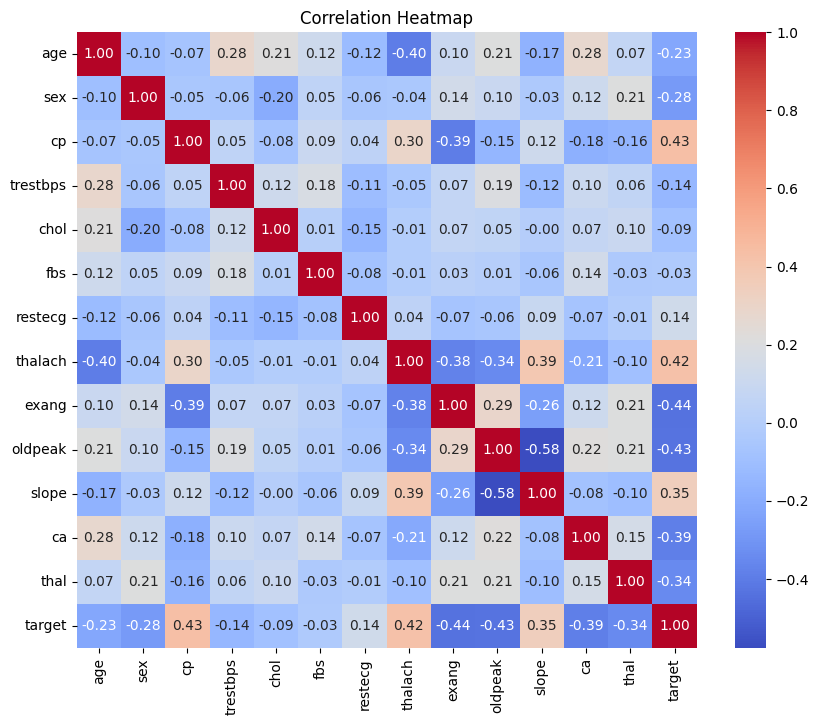

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(f"output/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

#### Feature Distribution

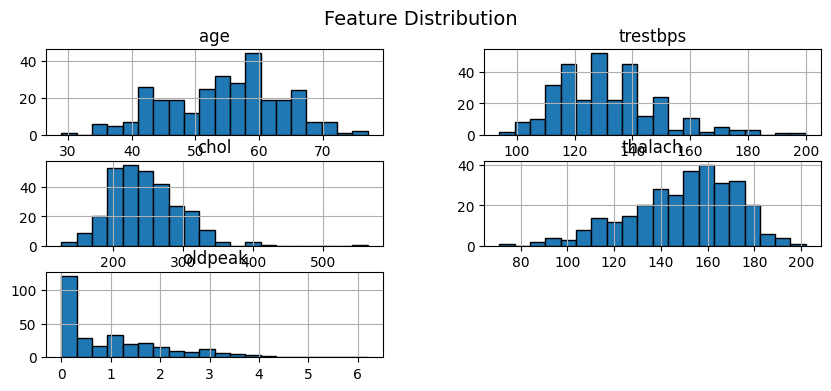

In [13]:
# Feature Distribution - Histograms
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[features].hist(figsize=(10, 4), bins=20, edgecolor='black')
plt.suptitle('Feature Distribution', fontsize=14)
plt.savefig(f"output/feature_distributions.png")
plt.show()

#### Target Distribution

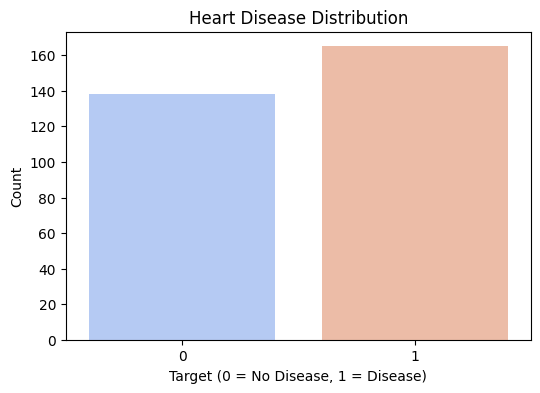

In [14]:
# Target Distribution - Bar Plot
feature = data['target']
plt.figure(figsize=(6, 4))
sns.countplot(x=feature, hue=feature, palette='coolwarm', legend=False)
plt.title("Heart Disease Distribution")
plt.xlabel("Target (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.savefig(f"output/target_distribution.png")
plt.show()

#### Boxplots

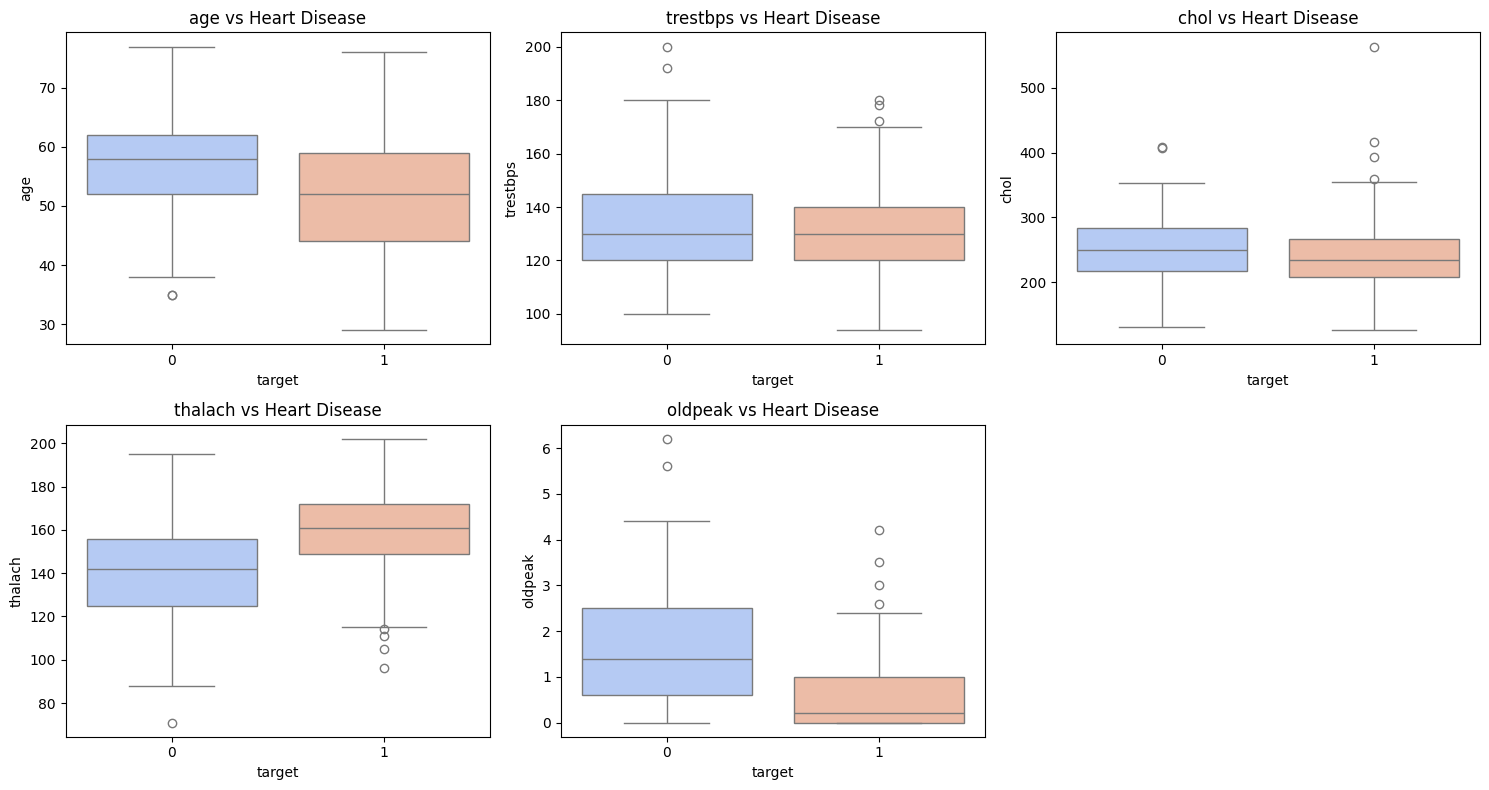

In [15]:
# Boxplots for Numerical Features
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i) # 2 rows, 3 columns layout
    sns.boxplot(x=data['target'], hue=data['target'], y=data[feature], palette='coolwarm', legend=False)
    plt.title(f'{feature} vs Heart Disease')
plt.tight_layout()
plt.savefig(f"output/boxplots.png")
plt.show()

### Train-Test Split & Normalisation
- Assuming no missing values; otherwise, imputation can be used

In [16]:
# Train-Test 80:20 split (80% training & 20% testing)
# Stratefy=y ; prevents class imbalance issued in ytrain & ytest
X, y = data.drop(columns='target'), data['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# Normalise the Data
# Improves model performance & prevents feature dominance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


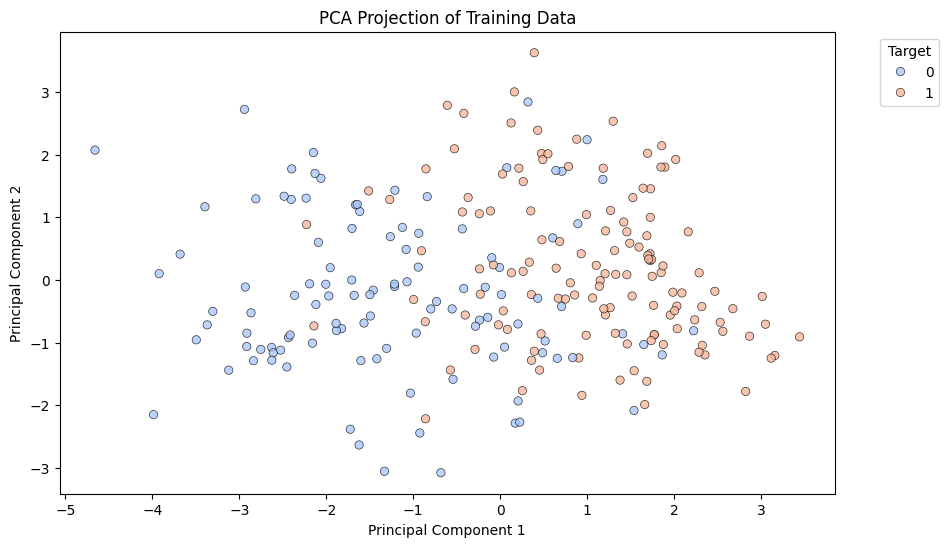

In [18]:
# Apply PCA (reduce to 2D for visualization)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
# Plot of data points in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="coolwarm", edgecolor="k", alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Training Data")
plt.legend(title="Target", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f"output/PCA_projection.png")
plt.show()

### Define Models to Compare

#### Justification for using each of the models:

1. Logistic Regression
    - Works well for linearly separable data and provides probabilistic interpretations.
    - Computationally efficient and less prone to overfitting with fewer features.

2. Random Forest
    - Reduces overfitting by averaging multiple decision trees (bagging).
    - Handles missing data and feature importance ranking well.

3. SVM (Support Vector Machine)
    - Effective for high-dimensional data and non-linearly separable cases using kernels.
    - Robust to outliers due to the use of support vectors.

4. XGBoost
    - Utilizes gradient boosting to minimize errors iteratively, improving accuracy.
    - Handles missing values and is highly optimized for speed and efficiency.
    - Works well with imbalanced datasets due to built-in regularization techniques.


In [19]:
# Random state = 42 ; used as a convention
models = {
    "Logistic Regression": LogisticRegression(max_iter=500,  warm_start=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}

### Model Evaluation

- TN (True Negative)
    - The model correctly predicted negative (No).
- FP (False Positives)
    - The model incorrectly predicted positive (Yes) when it was actually No (Type I Error).
- TP (True Positive)
    - The model correctly predicted positive (Yes).
- Accuracy = TP + TN / (TP + TN + FP + FN)
    - Overall correctness of the model.
- Precision = TP / (TP + FP)
    - No. of predicted positives that were actually positive.
- Recall (Sesitivity) = TP / (TP + FN)
    - Ability to detect positive cases (True Positive Rate).
- F1-Score = 2 *  Precision * Recall / (Precision + Recall)
    - Balance between precision and recall.
- MCC (Matthews Correlation Coefficient) = (TP * TN - FP * FN) / Square Root((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    - A balanced metric even for imbalanced datasets.
- Specificity = TN / (TN + FP)
    - Ability to detect negative cases (True Negative Rate).
- FPR (False Positive Rate) = FP / (FP + TN)
    - Probability of incorrectly predicting positive.
- FNR (False Negative Rate) = FN / (FN + TP)
    - Probability of missing a positive case.
- NPV (Negative Predictive Value) = TN / (TN + FP)
    - No. of predicted negatives that were actually negative
- FDR (False Discovery Rate) = FP / (TP + FP)
    - No. of predicted positives that were actually false.

In [20]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "MCC", "Specificity", "FPR", "FNR", "NPV", "FDR"]

def calculate_metrics(y_true, y_pred):
    # Confusion_matrix is a 2x2 array: [[TN, FP], [FN, TP]]
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    safe_division = lambda numerator, denominator: numerator / denominator if denominator > 0 else 0 # Prevents division by zero
    # Calculate metrics
    return {
        "Confusion Matrix": conf_matrix,
        "Accuracy": safe_division(TP + TN, TP + TN + FP + FN),
        "Precision": safe_division(TP, TP + FP),
        "Recall": safe_division(TP, TP + FN),
        "F1-Score": safe_division(2 * safe_division(TP, TP + FP) * safe_division(TP, TP + FN),
                                  safe_division(TP, TP + FP) + safe_division(TP, TP + FN)),
        "MCC": safe_division((TP * TN) - (FP * FN), np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))),
        "Specificity": safe_division(TN, TN + FP),
        "FPR": safe_division(FP, TN + FP),
        "FNR": safe_division(FN, TP + FN),
        "NPV": safe_division(TN, TN + FN),
        "FDR": safe_division(FP, TP + FP)
    }

def add_text(ax, confusion):
    title = [["TN", "FP"], ["FN", "TP"]]
    for (i, j), val in np.ndenumerate(confusion):
        ax.text(j + 0.2, i + 0.2, title[i][j], ha='left', va='top', color='black', fontsize=12, fontweight="bold")

def display_metrics(metrics):
    for metric_name, value in metrics.items():
        try:
            print(f"{metric_name}: {float(value):.4f}")
        except Exception:
            print(f"{metric_name}: {value}")

def display_model_results(model_name, metrics, save_path):
    print(f"Results for {model_name}:")
    display_metrics(metrics)
    confusion_matrix = metrics["Confusion Matrix"]
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
    add_text(plt, confusion_matrix)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### Train & Evaluate Confusion Matrix Plots (for each model)

In [21]:
# Initialise results
results = []

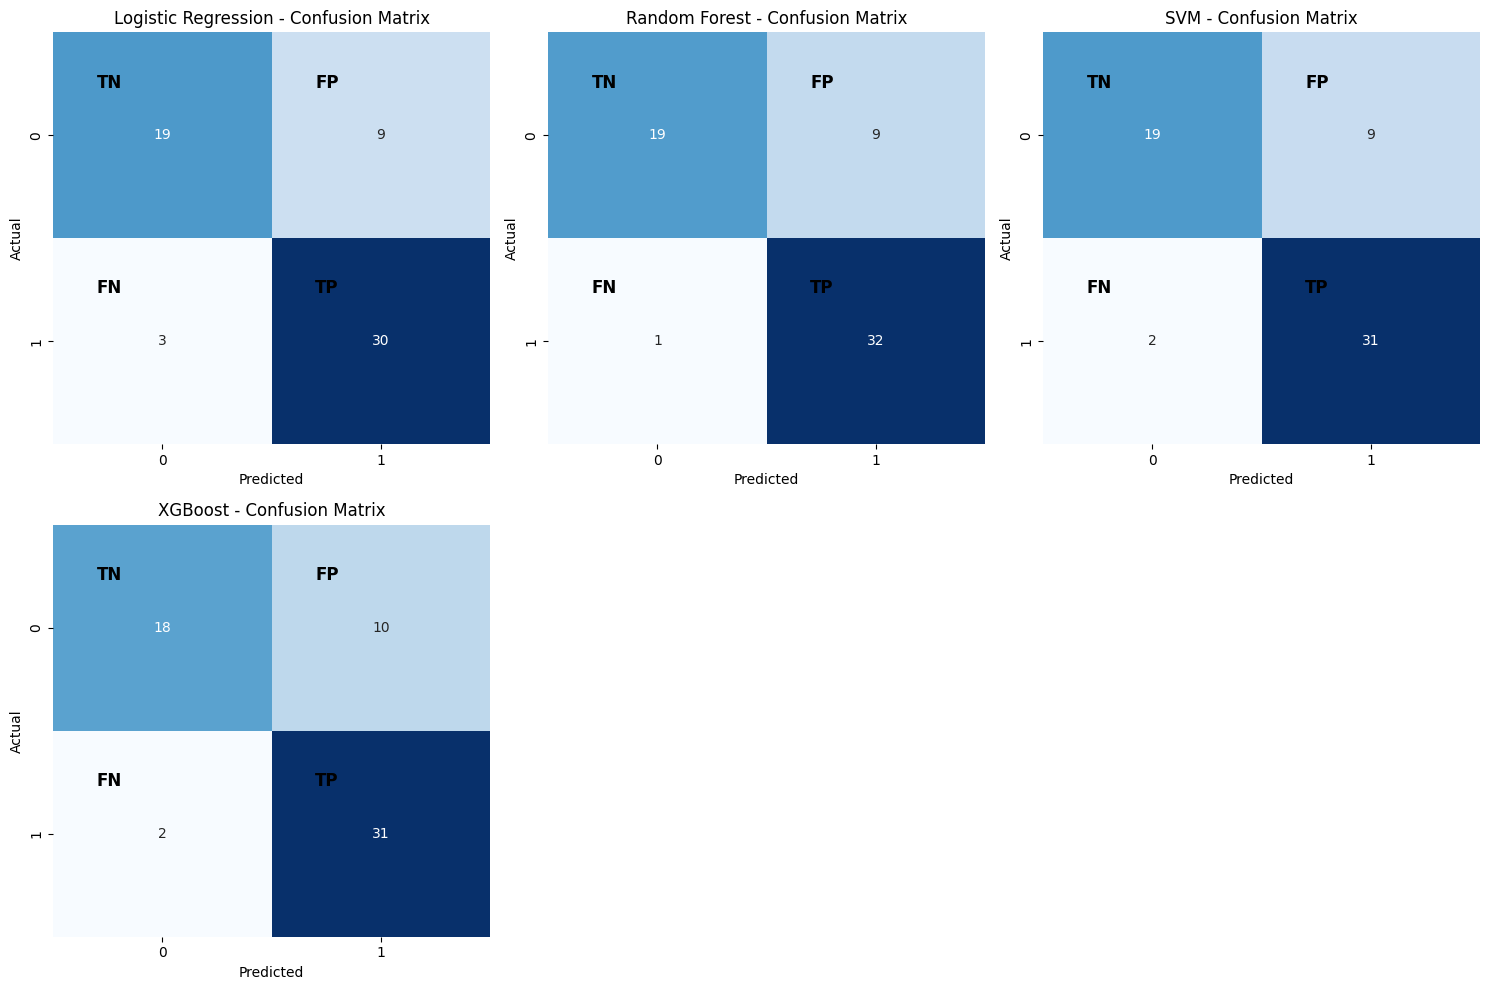

In [22]:
num_models = len(models)
rows = int(np.ceil(num_models / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    metrics = calculate_metrics(y_test, y_pred)
    confusion = metrics["Confusion Matrix"]
    results.append({
        "Model": name, **metrics
    })
    # Plot confusion matrix heatmap
    ax = axes[i]
    sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax)
    add_text(ax, confusion)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.savefig(f"output/{name.replace(' ', '_').lower()}/confusion_matrix.png", dpi=300, bbox_inches="tight")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

### Hyperparameter Tuning (Using GridSearchCV)

- Process of finding the best set of hyperparameters for a machine learning model to improve its performance
- Unlike model parameters (like weights in neural networks), hyperparameters must be set before training.
- I focused on hyperparameter tuning of RandomForestClassifier because it had the highest accuracy among all the models (Logistic Regression, Random Forest, SVM, XGBoost).

#### GridSearchcv

- A method in sklearn that automates hyperparameter tuning by testing different hyperparameter values and selecting the best combination.
- Tries all possible combinations of hyperparameters.
- CV (Cross-Validation) means it splits the data into training & validation sets multiple times to ensure generalization.

In [23]:
# # Logistic Regression

# lr_params = {
#     "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of the regularization parameter)
#     # "penalty": ["l1", "l2"],  # Different regularization methods
#     "solver": ["lbfgs", "saga"], # Optimisation algorithm (eg, 'lbfgs', 'saga')
#     "max_iter": [100, 200, 500] # Max no. of iterations allowed for the algorithm to converge
# }
# lr_clf = models["Logistic Regression"] # Initialise Logistic Regression Classifier

# # Grid Search with cross-validation
# grid_lr = GridSearchCV(lr_clf, lr_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
# grid_lr.fit(X_train_scaled, y_train)

# # Best Parameters & Model
# print("\n----- Hyperparameter Tuning Results (Logistic Regression) -----")
# print("Best Parameters:", grid_lr.best_params_)
# print("Best Accuracy Score:", grid_lr.best_score_)
# best_lr = grid_lr.best_estimator_ # Get the best Model
# results_lr = pd.DataFrame(grid_lr.cv_results_) # Convert GridSearchCV results into a DataFrame

# # Plot C vs. Accuracy Score
# plt.figure(figsize=(8, 5))
# plt.plot(results_lr["param_C"], results_lr["mean_test_score"], marker="o", linestyle="--")
# plt.xlabel("C (Regularization Parameter)")
# plt.ylabel("Mean CV Accuracy Score")
# plt.title("Logistic Regression Hyperparameter Tuning")
# plt.grid(True)
# plt.savefig("output/logistic_regression/hyperparameter_tuning.png", dpi=300, bbox_inches="tight")
# plt.show()

# # Train & evaluate the best model
# best_lr.fit(X_train_scaled, y_train)
# y_pred_lr_tuned = best_lr.predict(X_test_scaled)

# # Compute classification metrics
# metrics_lr_tuned = calculate_metrics(y_test, y_pred_lr_tuned)
# confusion_lr_tuned = metrics_lr_tuned["Confusion Matrix"]
# results.append({
#     "Model": "Logistic Regression (Tuned)",  **metrics_lr_tuned
# })
# plt.figure(figsize=(5, 4))
# sns.heatmap(confusion_lr_tuned, annot=True, cmap="Blues", fmt="d", cbar=False)
# add_text(plt, confusion_lr_tuned)
# plt.title("Logistic Regression (Tuned) - Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.savefig("output/logistic_regression/confusion_matrix_tuned.png", dpi=300, bbox_inches="tight")
# plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits

----- Hyperparameter Tuning Results (Random Forest) -----
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy Score: 0.8351190476190476


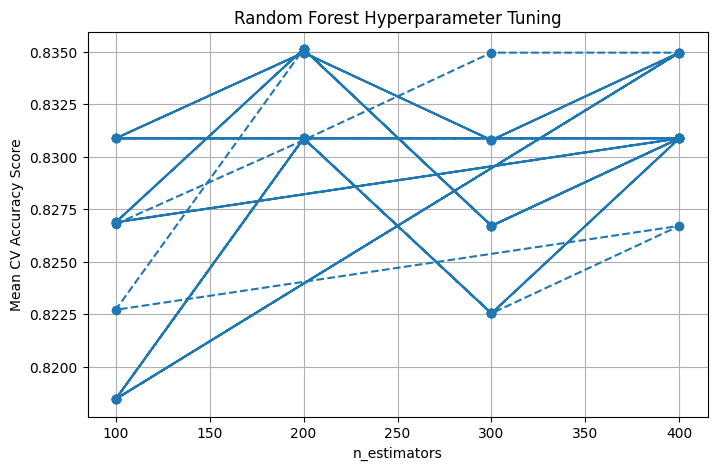

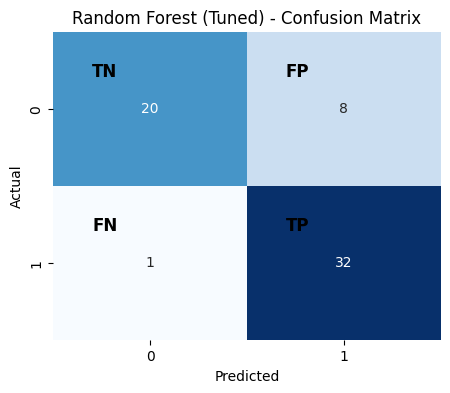

In [24]:
# Random Forest

random_forest_params = {
    'n_estimators': [100, 200, 300, 400],  # No. of trees included in the forest
    'max_depth': [10, 20, 30, None],  # Max depth of each tree
    'min_samples_split': [2, 5, 10],  # Min no. of samples needed to split each node
}
rf_clf = models["Random Forest"] # Initialise Random Forest Classifier

# Grid Search with cross-validation
grid_rf = GridSearchCV(rf_clf, random_forest_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_scaled, y_train)

# Best parameters & score
print("\n----- Hyperparameter Tuning Results (Random Forest) -----")
print("Best Parameters:", grid_rf.best_params_)
print("Best Accuracy Score:", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_ # Get the best Model
results_rf = pd.DataFrame(grid_rf.cv_results_) # Convert GridSearchCV results into a DataFrame

# Plot n_estimators vs. Accuracy Score
plt.figure(figsize=(8, 5))
plt.plot(results_rf["param_n_estimators"], results_rf["mean_test_score"], marker="o", linestyle="--")
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Accuracy Score")
plt.title("Random Forest Hyperparameter Tuning")
plt.grid(True)
plt.savefig("output/random_forest/hyperparameter_tuning.png", dpi=300, bbox_inches="tight")
plt.show()

# Train & evaluate the best model
best_rf.fit(X_train_scaled, y_train)
y_pred_rf_tuned = best_rf.predict(X_test_scaled)

# Compute classification metrics
metrics_rf_tuned = calculate_metrics(y_test, y_pred_rf_tuned)
confusion_rf_tuned = metrics_rf_tuned["Confusion Matrix"]
results.append({
    "Model": "Random Forest (Tuned)",  **metrics_rf_tuned
})
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_rf_tuned, annot=True, cmap="Blues", fmt="d", cbar=False)
add_text(plt, confusion_rf_tuned)
plt.title("Random Forest (Tuned) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("output/random_forest/confusion_matrix_tuned.png", dpi=300, bbox_inches="tight")
plt.show()

In [25]:
# # SVM

# svm_params = {
#     "C": [0.1, 1, 10, 100], # Regularization parameter
#     "kernel": ["linear", "rbf", "poly"],  # Types of kernels
#     "gamma": ["scale", "auto"], # Controls the influence of a single training example (for RBF/poly kernels)
# }
# svm_clf = models["SVM"] # Initialise SVM Classifier

# # Grid Search with cross-validation
# grid_svm = GridSearchCV(svm_clf, svm_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
# grid_svm.fit(X_train_scaled, y_train)

# # Best Parameters & Model
# print("\n----- Hyperparameter Tuning Results (SVM) -----")
# print("Best Parameters:", grid_svm.best_params_)
# print("Best Accuracy Score:", grid_svm.best_score_)
# best_svm = grid_svm.best_estimator_ # Get the best Model
# results_svm = pd.DataFrame(grid_svm.cv_results_) # Convert GridSearchCV results into a DataFrame

# # Plot C vs. Accuracy Score
# plt.figure(figsize=(8, 5))
# plt.plot(results_svm["param_C"], results_svm["mean_test_score"], marker="o", linestyle="--")
# plt.xlabel("C (Regularization Parameter)")
# plt.ylabel("Mean CV Accuracy Score")
# plt.title("SVM Hyperparameter Tuning")
# plt.grid(True)
# plt.savefig("output/svm/hyperparameter_tuning.png", dpi=300, bbox_inches="tight")
# plt.show()

# # Train & evaluate the best model
# best_svm.fit(X_train_scaled, y_train)
# y_pred_svm_tuned = best_svm.predict(X_test_scaled)

# # Compute classification metrics
# metrics_svm_tuned = calculate_metrics(y_test, y_pred_svm_tuned)
# confusion_svm_tuned = metrics_svm_tuned["Confusion Matrix"]
# results.append({
#     "Model": "SVM (Tuned)",  **metrics_svm_tuned
# })
# plt.figure(figsize=(5, 4))
# sns.heatmap(confusion_svm_tuned, annot=True, cmap="Blues", fmt="d", cbar=False)
# add_text(plt, confusion_svm_tuned)
# plt.title("SVM (Tuned) - Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.savefig("output/svm/confusion_matrix_tuned.png", dpi=300, bbox_inches="tight")
# plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits


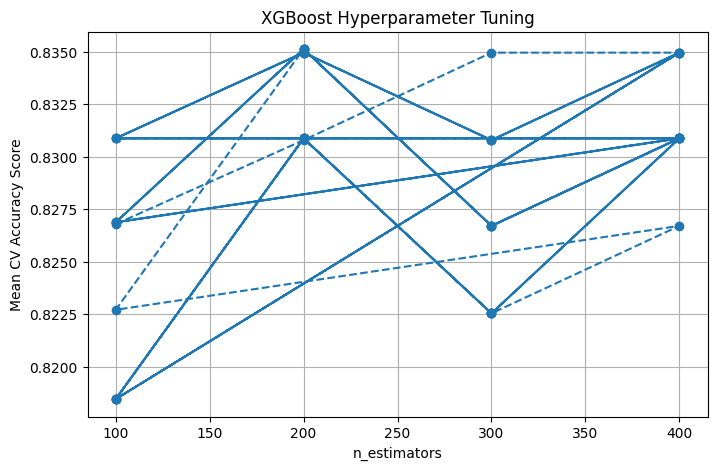


----- Hyperparameter Tuning Results (XGBoost) -----
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}
Best Accuracy Score: 0.8473639455782314


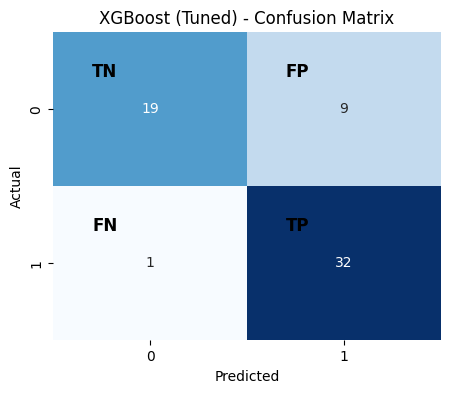

In [26]:
# XGBoost

xgb_params = {
    "n_estimators": [100, 300, 500], # No. of boosting iterations
    "learning_rate": [0.01, 0.1, 0.3], # Learning rate used to prevent overfitting
    "max_depth": [3, 5, 7], # Max depth of the trees, which controls their complexity
    "subsample": [0.7, 0.9, 1.0], # Fraction of training data used per boosting iteration
}
xgb_clf = models["XGBoost"] # Initialise XGBoost Classifier

# Grid Search with cross-validation
grid_xgb = GridSearchCV(xgb_clf, xgb_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_scaled, y_train)

# Plot n_estimators vs. Accuracy Score
plt.figure(figsize=(8, 5))
plt.plot(results_rf["param_n_estimators"], results_rf["mean_test_score"], marker="o", linestyle="--")
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Accuracy Score")
plt.title("XGBoost Hyperparameter Tuning")
plt.grid(True)
plt.savefig("output/xgboost/hyperparameter_tuning.png", dpi=300, bbox_inches="tight")
plt.show()

# Best Parameters & Model
print("\n----- Hyperparameter Tuning Results (XGBoost) -----")
print("Best Parameters:", grid_xgb.best_params_)
print("Best Accuracy Score:", grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_ # Get the best model
results_cv = pd.DataFrame(grid_xgb.cv_results_) # Convert GridSearchCV results into a DataFrame

# Train & evaluate the best model
best_xgb.fit(X_train_scaled, y_train)
y_pred_xgb_tuned = best_xgb.predict(X_test_scaled)

# Compute classification metrics
metrics_xgb_tuned = calculate_metrics(y_test, y_pred_xgb_tuned)
confusion_xgb_tuned = metrics_xgb_tuned["Confusion Matrix"]
results.append({
    "Model": "XGBoost (Tuned)",  **metrics_xgb_tuned
})
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_xgb_tuned, annot=True, cmap="Blues", fmt="d", cbar=False)
add_text(plt, confusion_xgb_tuned)
plt.title("XGBoost (Tuned) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("output/xgboost/confusion_matrix_tuned.png", dpi=300, bbox_inches="tight")
plt.show()

### Comparison of Models & their Metrics


------- Model Comparison Table -------
                    Model  Accuracy  Precision  Recall  F1-Score     MCC  \
4  Random Forest (Tuned)    0.8525     0.8000  0.9697    0.8767  0.7174   
1          Random Forest    0.8361     0.7805  0.9697    0.8649  0.6882   
5        XGBoost (Tuned)    0.8361     0.7805  0.9697    0.8649  0.6882   
2                    SVM    0.8197     0.7750  0.9394    0.8493  0.6481   
0    Logistic Regression    0.8033     0.7692  0.9091    0.8333  0.6098   
3                XGBoost    0.8033     0.7561  0.9394    0.8378  0.6181   

   Specificity     FPR     FNR     NPV     FDR  
4       0.7143  0.2857  0.0303  0.9524  0.2000  
1       0.6786  0.3214  0.0303  0.9500  0.2195  
5       0.6786  0.3214  0.0303  0.9500  0.2195  
2       0.6786  0.3214  0.0606  0.9048  0.2250  
0       0.6786  0.3214  0.0909  0.8636  0.2308  
3       0.6429  0.3571  0.0606  0.9000  0.2439  

Model comparison saved as 'model_comparison.csv' in the output folder.


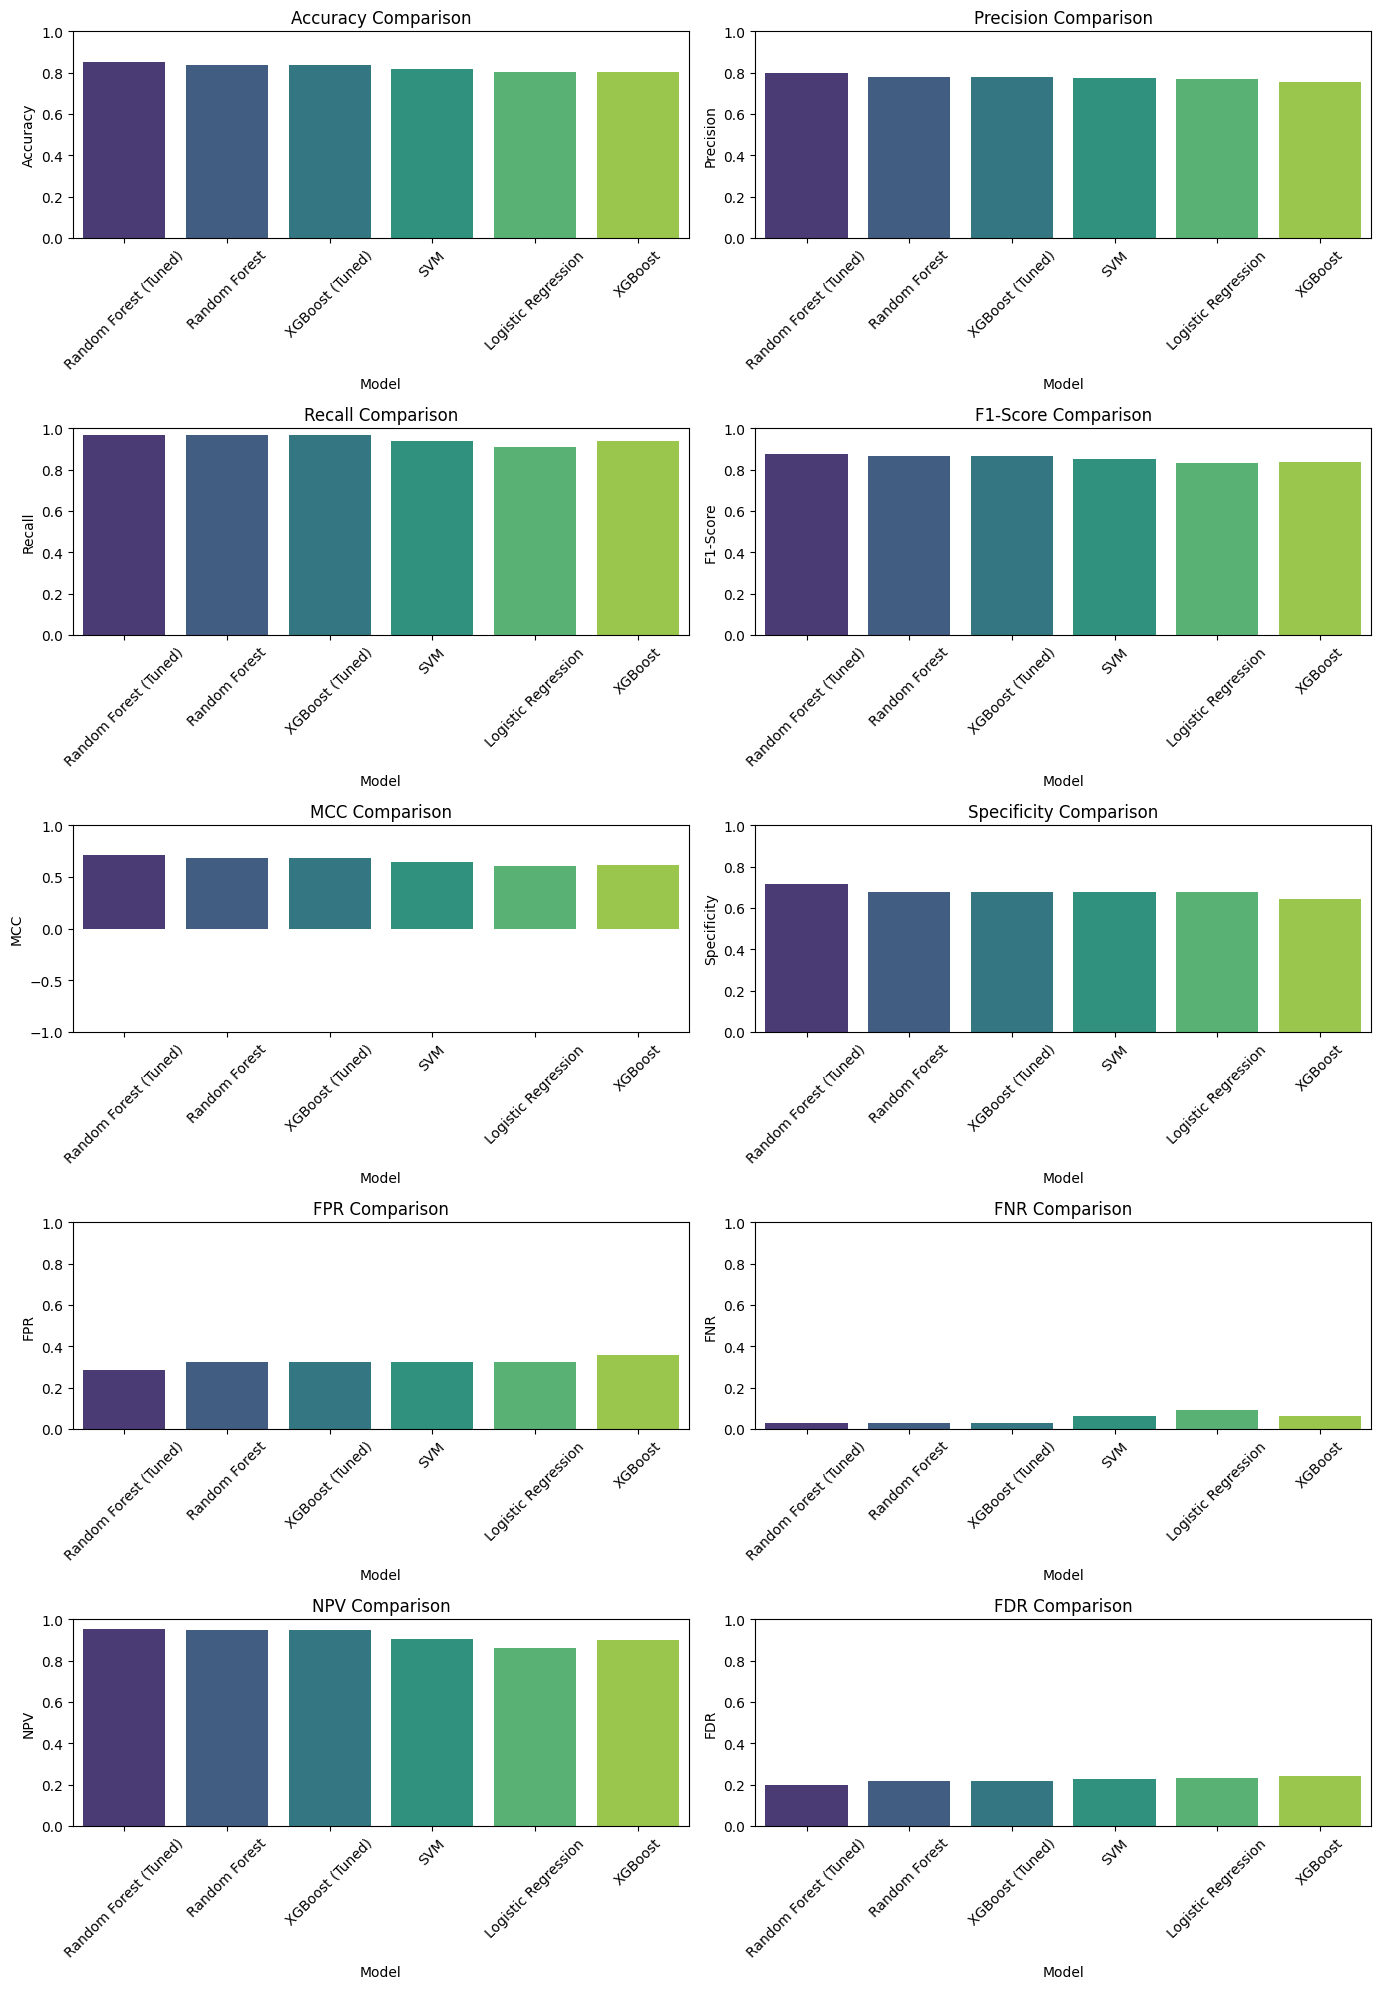

In [27]:
# Convert results to DataFrame & sort
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Ensure all values in metrics columns are numeric scalars (not arrays)
numeric_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "MCC", "Specificity", "FPR", "FNR", "NPV", "FDR"]
results_df[numeric_cols] = results_df[numeric_cols].apply(pd.to_numeric, errors="coerce")
results_df["Model"] = results_df["Model"].astype(str)

# Print the results table
print("\n------- Model Comparison Table -------\n", results_df[["Model"] + numeric_cols].round(4))
results_df.to_csv("output/model_comparison.csv", index=False)
print("\nModel comparison saved as 'model_comparison.csv' in the output folder.")

# Plot metrics
metrics = numeric_cols
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics // n_cols) + (n_metrics % n_cols > 0)
plt.figure(figsize=(14, n_rows * 4))

for i, metric in enumerate(metrics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis", errorbar=None)
    plt.title(f"{metric} Comparison")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    # MCC ranges from -1 to 1, others from 0 to 1
    plt.ylim(-1, 1) if metric == "MCC" else plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join("output/evaluation_metrics.png"), dpi=300, bbox_inches="tight")
plt.show()

#### Training Visualisation

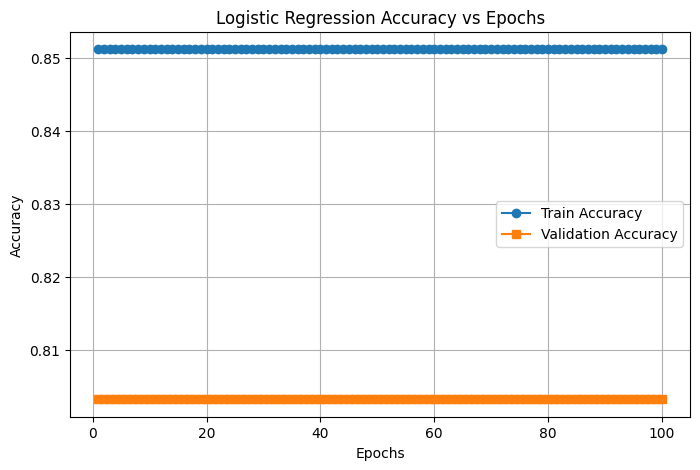

In [28]:
# Logistic Regression Training and Accuracy vs. Epochs
log_reg = models["Logistic Regression"]
train_acc = []
val_acc = []
for epoch in range(1, 101):
    log_reg.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, log_reg.predict(X_train)))
    val_acc.append(accuracy_score(y_test, log_reg.predict(X_test)))
plt.figure(figsize=(8, 5))
plt.plot(range(1, 101), train_acc, label='Train Accuracy', marker='o')
plt.plot(range(1, 101), val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs Epochs')
plt.legend()
plt.grid()
plt.savefig("output/logistic_regression_accuracy_vs_epochs.png", dpi=300, bbox_inches="tight")
plt.show()

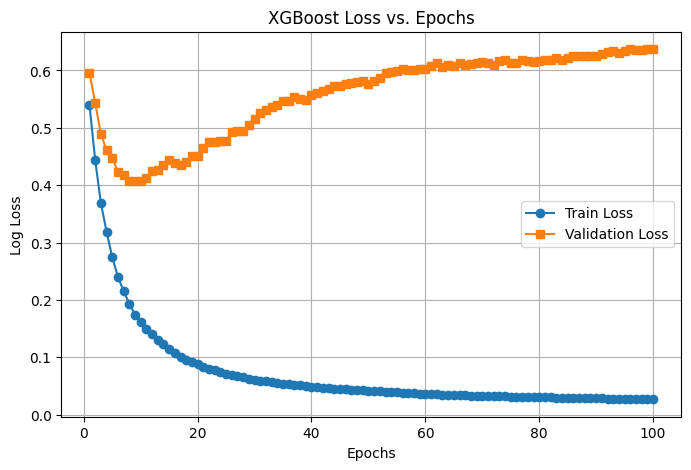

In [29]:
# XGBoost Training and Loss vs. Epochs
xgb_model = models["XGBoost"]
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)
# Extract Log Loss from XGBoost Training
results = xgb_model.evals_result()
xgb_train_loss = results['validation_0']['logloss']
xgb_val_loss = results['validation_1']['logloss']
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(xgb_train_loss) + 1), xgb_train_loss, label='Train Loss', marker='o')
plt.plot(range(1, len(xgb_val_loss) + 1), xgb_val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()

### Ensemble Prediction
Ensemble learning combines multiple models to improve performance, reduce variance, and enhance generalization. Different ensemble techniques, such as Voting Classifiers and Stacking Classifiers, can be used for better predictive accuracy

### Oversampling
Oversampling techniques, such as SMOTE (Synthetic Minority Over-sampling Technique), are used to handle class imbalance by generating synthetic samples for the minority class. This helps improve model performance, especially in datasets where one class is significantly underrepresented.

#### Soft Voting
- Soft voting averages the predicted probabilities from multiple base classifiers and selects the class with the highest probability.
- It considers confidence levels from different models, leading to a more stable and accurate prediction

### Hard Voting
- Hard voting takes the majority vote from multiple base classifiers and assigns the final class based on the most common prediction.
- Simple and robust but does not consider confidence scores.

#### Stacking Classifier
- Stacking (Stacked Generalization) is an advanced ensemble technique where predictions from multiple base models are combined as input to a meta-model (e.g., Logistic Regression).
- More powerful than voting classifiers as it learns how to optimally combine different model's outputs.

In [30]:
base_models = [
    ("lr", models["Logistic Regression"]),
    # ("lr_best", best_lr),
    ("rf", models["Random Forest"]),
    ("rf_best", best_rf),
    ("svm", models["SVM"]),
    # ("svm_best", best_svm),
    ("xgb", models["XGBoost"]),
    ("xgb_best", best_xgb)
]

ensemble_models = [
    "Soft Voting (Before SMOTE, Tuned)",
    "Hard Voting (Before SMOTE, Tuned)",
    "Stacking (Before SMOTE, Tuned)",
    "Soft Voting (After SMOTE, Tuned)",
    "Hard Voting (After SMOTE, Tuned)",
    "Stacking (After SMOTE, Tuned)"
]

In [31]:
#Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))  # Should be balanced

Before SMOTE: Counter({1: 132, 0: 110})
After SMOTE: Counter({1: 132, 0: 132})


Confusion Matrix: [[18 10]
 [ 1 32]]
Accuracy: 0.8197
Precision: 0.7619
Recall: 0.9697
F1-Score: 0.8533
MCC: 0.6591
Specificity: 0.6429
FPR: 0.3571
FNR: 0.0303
NPV: 0.9474
FDR: 0.2381


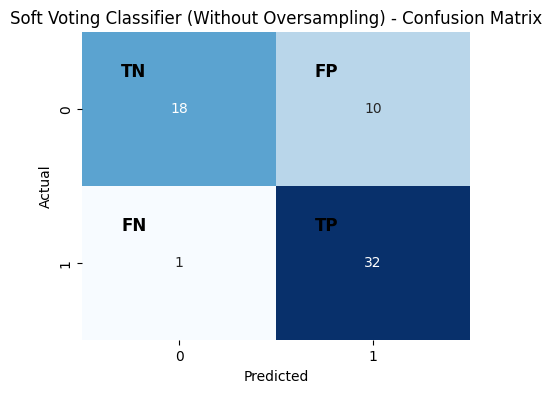

Confusion Matrix: [[20  8]
 [ 1 32]]
Accuracy: 0.8525
Precision: 0.8000
Recall: 0.9697
F1-Score: 0.8767
MCC: 0.7174
Specificity: 0.7143
FPR: 0.2857
FNR: 0.0303
NPV: 0.9524
FDR: 0.2000


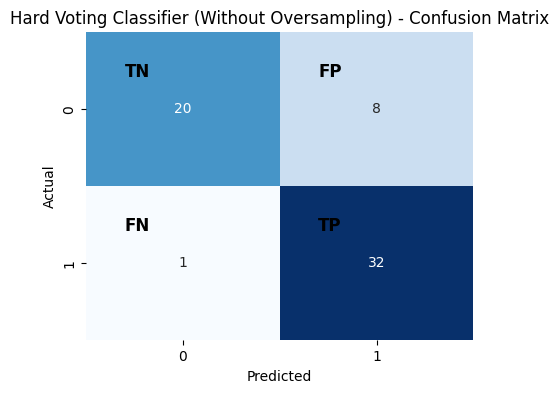

Confusion Matrix: [[19  9]
 [ 2 31]]
Accuracy: 0.8197
Precision: 0.7750
Recall: 0.9394
F1-Score: 0.8493
MCC: 0.6481
Specificity: 0.6786
FPR: 0.3214
FNR: 0.0606
NPV: 0.9048
FDR: 0.2250


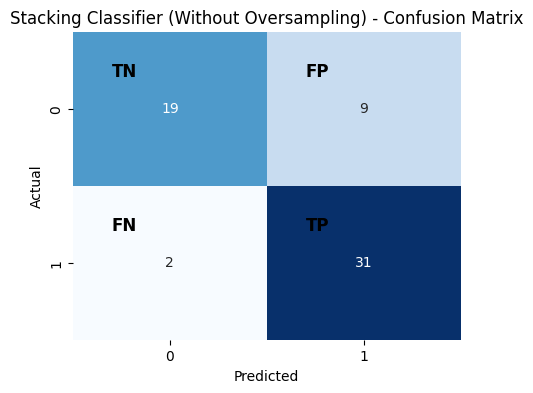

In [32]:
# Before Oversampling

# Soft Voting Classifier (Without Oversampling)
soft_voting_clf = VotingClassifier(estimators=base_models, voting="soft")
soft_voting_clf.fit(X_train_scaled, y_train)
y_pred_soft = soft_voting_clf.predict(X_test_scaled)
soft_voting_metrics = calculate_metrics(y_test, y_pred_soft)
display_model_results(
    "Soft Voting Classifier (Without Oversampling)",
    soft_voting_metrics,
    "output/ensemble/soft_voting/confusion_matrix.png"
)

# Hard Voting Classifier (Without Oversampling)
hard_voting_clf = VotingClassifier(estimators=base_models, voting="hard")
hard_voting_clf.fit(X_train_scaled, y_train)
y_pred_hard = hard_voting_clf.predict(X_test_scaled)
hard_voting_metrics = calculate_metrics(y_test, y_pred_hard)
display_model_results(
    "Hard Voting Classifier (Without Oversampling)",
    hard_voting_metrics,
    "output/ensemble/hard_voting/confusion_matrix.png"
)

# Stacking Classifier (Without Oversampling)
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=1000))
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)
stacking_metrics = calculate_metrics(y_test, y_pred_stacking)
display_model_results(
    "Stacking Classifier (Without Oversampling)",
    stacking_metrics,
    "output/ensemble/stacking/confusion_matrix.png"
)

Confusion Matrix: [[19  9]
 [ 4 29]]
Accuracy: 0.7869
Precision: 0.7632
Recall: 0.8788
F1-Score: 0.8169
MCC: 0.5731
Specificity: 0.6786
FPR: 0.3214
FNR: 0.1212
NPV: 0.8261
FDR: 0.2368


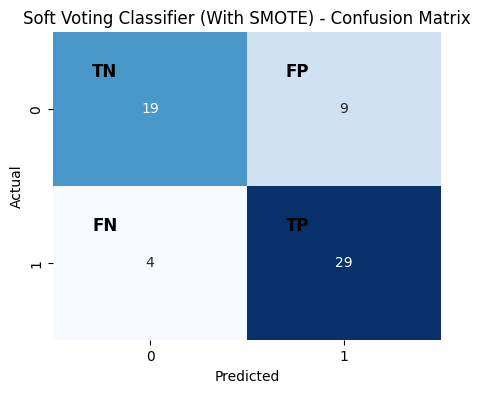

Confusion Matrix: [[20  8]
 [ 3 30]]
Accuracy: 0.8197
Precision: 0.7895
Recall: 0.9091
F1-Score: 0.8451
MCC: 0.6410
Specificity: 0.7143
FPR: 0.2857
FNR: 0.0909
NPV: 0.8696
FDR: 0.2105


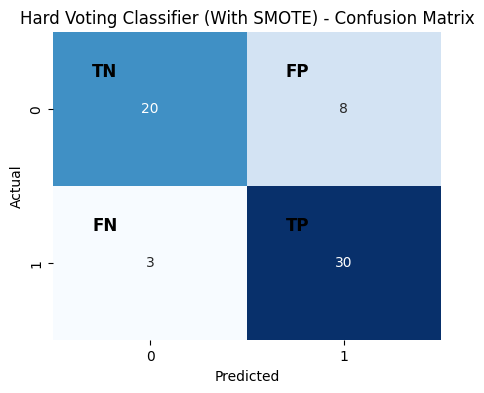

Confusion Matrix: [[20  8]
 [ 3 30]]
Accuracy: 0.8197
Precision: 0.7895
Recall: 0.9091
F1-Score: 0.8451
MCC: 0.6410
Specificity: 0.7143
FPR: 0.2857
FNR: 0.0909
NPV: 0.8696
FDR: 0.2105


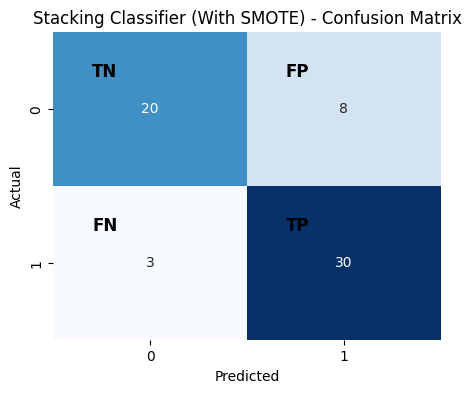

In [33]:
# After Oversampling

# Soft Voting Classifier (With Oversampling)
soft_voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_soft_smote = soft_voting_clf.predict(X_test_scaled)
soft_voting_metrics_smote = calculate_metrics(y_test, y_pred_soft_smote)
display_model_results(
    "Soft Voting Classifier (With SMOTE)",
    soft_voting_metrics_smote,
    "output/ensemble/soft_voting/confusion_matrix_smote.png"
)

# Hard Voting Classifier (With Oversampling)
hard_voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_hard_smote = hard_voting_clf.predict(X_test_scaled)
hard_voting_metrics_smote = calculate_metrics(y_test, y_pred_hard_smote)
display_model_results(
    "Hard Voting Classifier (With SMOTE)",
    hard_voting_metrics_smote,
    "output/ensemble/hard_voting/confusion_matrix_smote.png"
)

# Stacking Classifier (With Oversampling)
stacking_clf.fit(X_train_resampled, y_train_resampled)
y_pred_stacking_smote = stacking_clf.predict(X_test_scaled)
stacking_metrics_smote = calculate_metrics(y_test, y_pred_stacking_smote)
display_model_results(
    "Stacking Classifier (With SMOTE)",
    stacking_metrics_smote,
    "output/ensemble/stacking/confusion_matrix_smote.png"
)

### Comparing Various Ensemble Models

In [34]:
ensemble_model_results = [
    soft_voting_metrics,  # Before SMOTE
    hard_voting_metrics,  # Before SMOTE
    stacking_metrics,     # Before SMOTE
    soft_voting_metrics_smote,  # After SMOTE
    hard_voting_metrics_smote,  # After SMOTE
    stacking_metrics_smote  # After SMOTE
]
comparison_table = pd.DataFrame({
    "Model": ensemble_models,
    **{metric: [round(m[metric], 4) for m in ensemble_model_results] for metric in metrics}
})
print("\n------ Model Performance Comparison ------\n")
print(tabulate(comparison_table, headers='keys', tablefmt='pretty'))
comparison_table.to_csv("output/ensemble_comparison.csv", index=False)
print("\nComparison table saved as output/ensemble_comparison.csv")


------ Model Performance Comparison ------

+---+-----------------------------------+----------+-----------+--------+----------+--------+-------------+--------+--------+--------+--------+
|   |               Model               | Accuracy | Precision | Recall | F1-Score |  MCC   | Specificity |  FPR   |  FNR   |  NPV   |  FDR   |
+---+-----------------------------------+----------+-----------+--------+----------+--------+-------------+--------+--------+--------+--------+
| 0 | Soft Voting (Before SMOTE, Tuned) |  0.8197  |  0.7619   | 0.9697 |  0.8533  | 0.6591 |   0.6429    | 0.3571 | 0.0303 | 0.9474 | 0.2381 |
| 1 | Hard Voting (Before SMOTE, Tuned) |  0.8525  |    0.8    | 0.9697 |  0.8767  | 0.7174 |   0.7143    | 0.2857 | 0.0303 | 0.9524 |  0.2   |
| 2 |  Stacking (Before SMOTE, Tuned)   |  0.8197  |   0.775   | 0.9394 |  0.8493  | 0.6481 |   0.6786    | 0.3214 | 0.0606 | 0.9048 | 0.225  |
| 3 | Soft Voting (After SMOTE, Tuned)  |  0.7869  |  0.7632   | 0.8788 |  0.8169  | 0.5731

### Results of Final Hybrid Model (Hard Voting - Before SMOTE)

- Hard voting has the highest accuracy (0.8525) and MCC (0.7174), making it the best choice

Confusion Matrix: [[20  8]
 [ 1 32]]
Accuracy: 0.8525
Precision: 0.8000
Recall: 0.9697
F1-Score: 0.8767
MCC: 0.7174
Specificity: 0.7143
FPR: 0.2857
FNR: 0.0303
NPV: 0.9524
FDR: 0.2000


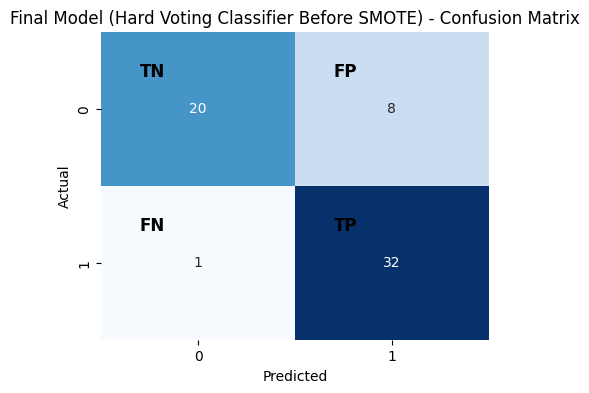

In [39]:
# Hard Voting Classifier (Without SMOTE)
final_model = VotingClassifier(estimators=base_models, voting="hard")
final_model.fit(X_train_scaled, y_train)
y_final_pred  = final_model.predict(X_test_scaled)
final_model_metrics = calculate_metrics(y_test, y_pred_hard)
display_model_results(
    "Final Model (Hard Voting Classifier Before SMOTE)",
    final_model_metrics,
    "output/final_model_confusion_matrix.png"
)

### Save the Ensemble Models

In [41]:
with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Model saved as 'ensemble_model.pkl'")

Model saved as 'ensemble_model.pkl'


### Predict using each Ensemble Model

In [42]:
# Load the trained ensemble model
with open("ensemble_model.pkl", "rb") as f:
    voting_clf = pickle.load(f)
# Load scaler (used to scale the inputs
scaler = joblib.load("scaler.pkl")

# Define input widgets for user input (modify according to your dataset features)
feature_inputs = {
    "age": widgets.FloatText(description="Age:"),
    "sex": widgets.IntSlider(description="Sex:", min=0, max=1),  # 0 = Female, 1 = Male
    "cp": widgets.IntSlider(description="Chest Pain:", min=0, max=3),  # Chest pain type (0-3)
    "trestbps": widgets.FloatText(description="Resting Blood Pressure:"),
    "chol": widgets.FloatText(description="Cholesterol:"),
    "fbs": widgets.IntSlider(description="FBS > 120 mg/dl:", min=0, max=1),  # Fasting blood sugar
    "restecg": widgets.IntSlider(description="Rest ECG:", min=0, max=2),  # Resting ECG results
    "thalach": widgets.FloatText(description="Max Heart Rate:"),
    "exang": widgets.IntSlider(description="Exercise:", min=0, max=1),
    "oldpeak": widgets.FloatText(description="ST Depression:"),
    "slope": widgets.IntSlider(description="Slope:", min=0, max=2),
    "ca": widgets.IntSlider(description="Major Vessels (0-3):", min=0, max=3),
    "thal": widgets.IntSlider(description="Thalassemia Type:", min=0, max=3)  # 1 = Normal, 2 = Fixed Defect, 3 = Reversible Defect
}

# Prediction function
def make_prediction(_):
    # user_input = np.array([[70, 1, 2, 160, 269, 0, 1, 112, 1, 2.9, 1, 1, 3]]) # => 0
    user_input = np.array([[49, 1, 2, 118, 149, 0, 0, 126, 0, 0.8, 2, 3, 2]]) # => 1
    # user_input = np.array([[w.value for w in feature_inputs.values()]])
    user_input_scaled = scaler.transform(user_input)
    prediction = voting_clf.predict(user_input_scaled)
    print(f"\nPredicted Outcome: {prediction[0]}")

# Display input fields
# input_box = widgets.VBox(list(feature_inputs.values()))
# display(input_box)

# Predict button
predict_button = widgets.Button(description="Predict")
predict_button.on_click(make_prediction)
display(predict_button)

# Example inputs:
# [54, 0, 2, 160, 201, 0, 1, 163, 0, 0, 2, 1, 2] => 1
# [70, 1, 2, 160, 269, 0, 1, 112, 1, 2.9, 1, 1, 3] => 0
# [49, 1, 2, 118, 149, 0, 0, 126, 0, 0.8, 2, 3, 2]  => 1


Button(description='Predict', style=ButtonStyle())


Predicted Outcome: 1
